# Next Steps (1/5/21)

## 1/5/21

- get signed variable importances for regression models

- case study for strongest TSS model: do genes with strong secondary TSS do worse?

- what is minimal set of features we can augment 1-hot with to get better generalization?
    - simplify 1-hot via featurization
    - augment 1-hot with cherry-picked additional features
    
- take first step towards an inventory of feature engineering decisions/parameters

- divide genes by expression and fit individual regressors on each subset

## 12/18/20

- get feedback
- error analysis -> which cases are the models getting right vs wrong?
- look at variable importances for SVR and RF
- can we classify low, medium, and highly expressed genes? 
    - and if so, can we make quantitative models for just these buckets?
- how do we handle slightly offset TSS for same promoter?
    - investigate these cases and compare: offset between TSS, difference in TSS signal height
    - try to align promoters by -10 box, not TSS
        - profile: is this an issue?
- within TU vs random expression for E. coli
- [lost to aether of Dan's mind]
    
- Do our features incorporate base pair relationships?
    - kmers -> count di- or tri-nucleotides
        - drawback: blows up the number of features
    - one-hot -> no
    - more sophisticated model architecture -> recurrent neural networks
        - these require much more data typically (tens of thousands of samples)

- can we get more data?
    - synthetic promoter libraries
    - are there promoter libraries that haven't already been used for this exact purpose but are out there?

# Import Packages and Construct Bitome

In [1]:
from itertools import chain, product
import os
from pathlib import Path
import shutil
import subprocess
import sys

from Bio.SeqUtils import GC
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pingouin import multicomp
from scipy.stats import f_oneway, gaussian_kde, mannwhitneyu, ttest_ind
import seaborn as sns
import shap
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.metrics import confusion_matrix, r2_score
from sklearn.model_selection import cross_validate, train_test_split, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from weblogo import *

sys.path.append('../../bitome2')
sys.path.append('../')

from bitome.core import Bitome
from bitome.util import create_motif, genome_point_to_point, score_motif_match

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 30)

In [2]:
M_FLORUM_DATA_PATH = Path('../data/bitome2/m_florum')

In [3]:
# terminus is assumed to be at the opposite end from the origin
m_florum = Bitome(
    Path(M_FLORUM_DATA_PATH, 'Mesoplasma_florum_L1.fasta'),
    origin=(1, 1), terminus=(396612, 396612),
    gene_table=Path(M_FLORUM_DATA_PATH, 'gene.csv'),
    terminator_table=Path(M_FLORUM_DATA_PATH, 'terminator.csv'),
    tss_table=Path(M_FLORUM_DATA_PATH, 'tss.csv'),
    tu_table=Path(M_FLORUM_DATA_PATH, 'tu.csv')
)

In [4]:
m_florum.gene_table.head()

,left,right,strand,KO,category,subcategory,subsubcategory,product_name,name,fpkm,primary_tu,log_fpkm
locus_tag,,,,,,,,,,,,
peg.1,1.0,1332.0,1,K02313,Genetic Information Processing,DNA Maintenance,DNA replication and partition,"dnaA, chromosomal replication initiator protein",dnaA,192.793077,NaN,5.266791
peg.2,1560.0,2681.0,1,K02338,Genetic Information Processing,DNA Maintenance,DNA replication and partition,"dnaN, DNA polymerase III subunit beta [EC:2.7....",dnaN,642.952373,TU_002,6.467625
peg.3,2708.0,3682.0,-1,K03569,Cellular Processes,Cytoskeleton,Cytoskeleton proteins,"mreB, rod shape-determining protein MreB and r...",mreB,2046.205311,TU_004,7.624231
peg.4,3751.0,4278.0,1,K05985,Genetic Information Processing,"Folding, Sorting and Degradation",Nucleases,"rnmV, ribonuclease M5 [EC:3.1.26.8]",rnmV,8.156475,TU_005,2.214461
peg.5,4280.0,5083.0,1,K02528,Genetic Information Processing,Translation,Ribosome biogenesis,"ksgA, 16S rRNA (adenine1518-N6/adenine1519-N6)...",ksgA,215.862583,TU_005,5.379264


# Investigate Expression

Ultimately the TU is what is transcribed; but how consistent are the FPKM values for the genes within a single TU? Of course this only applies to TUs with multiple genes

## Variance within TUs

In [6]:
tu_expression_dict = {}

# to avoid -inf with log
ETA = 1

gene_counts = []
for tu_row in m_florum.tu_table.itertuples():
    genes = list(set(tu_row.gene_names.split(';')).intersection(set(list(m_florum.gene_table.index))))
    gene_expressions = np.log(np.array(m_florum.gene_table.loc[genes, 'fpkm']) + ETA)
    if len(gene_expressions) > 1:
        tu_expression_dict[tu_row.Index] = gene_expressions
        gene_counts.append(len(gene_expressions))
        
print(f'Most genes in single TU: {max(gene_counts)}')

Most genes in single TU: 21


Text(0.5, 0.87, 'P=3.89E-06')

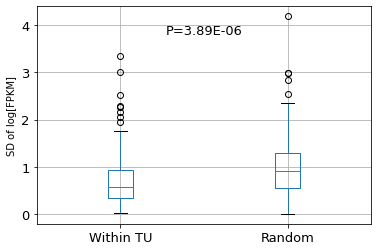

In [7]:
sd_within_tu = [np.std(exps) for exps in tu_expression_dict.values()]

# bootstrap by random sample groups of genes and getting their standard deviations; have to random sample 
# the number of genes too; sample from the same distribution as the empirical one

tu_size_kde = gaussian_kde(gene_counts)

sds_random = []
for i in range(len(sd_within_tu)):
    rand_n_genes = int(max(2, np.round(tu_size_kde.resample(1).flatten()[0])))
    gene_idxes = np.random.choice(len(sd_within_tu), rand_n_genes)
    exps = np.log(np.array(m_florum.gene_table.iloc[gene_idxes, :]['fpkm']) + ETA)
    sds_random.append(np.std(exps))
    
t_stat, p_val = ttest_ind(sd_within_tu, sds_random, equal_var=False)
    
tu_exp_sd_df = pd.DataFrame(data={'Within TU': sd_within_tu, 'Random': sds_random})
ax = tu_exp_sd_df.boxplot()
ax.tick_params(axis='both', labelsize=13)
ax.set_ylabel('SD of log[FPKM]')
ax.text(0.5, 0.87, f'P={p_val:.2E}', fontsize=13, transform=ax.transAxes, ha='center')

Okay, so it does seem visually as though variance in detected expression for genes within the same TU is markedly lower than that of randomly selected genes. However, there is still some decent variation there.

So we should try:
- predicting the average expression of the TU from the constituent genes based on TU's promoter
- predicting the expression of the first gene in the TU from the promoter
- using all gene expressions individually but with same promoter if in same TU (this seems like it'll be toughest for the model if the genes in the TU have different expressions; it'll be a duplicate sample with a different target value?)
- averaging the promoters associated with the same gene

## Expression Distribution

Text(0.5, 1.0, 'M. florum Gene Expression Distribution')

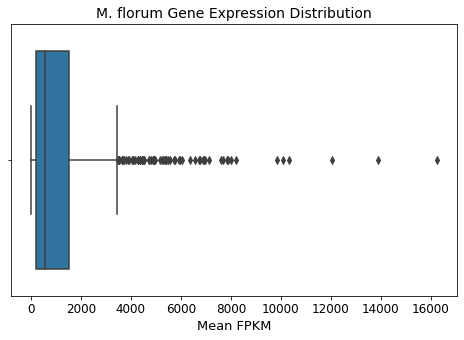

In [8]:
_, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(x='fpkm', data=m_florum.gene_table, ax=ax)
ax.set_xlabel('Mean FPKM', fontsize=13)
ax.tick_params(axis='x', labelsize=12)
ax.set_title('M. florum Gene Expression Distribution', fontsize=14)

In [ ]:
gene_table_log = m_florum.gene_table.copy()
gene_table_log['log_fpkm'] = gene_table_log['mean_fpkm'].apply(np.log)

In [ ]:
_, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(x='log_fpkm', data=gene_table_log, ax=ax)
ax.set_xlabel('Log FPKM', fontsize=13)
ax.tick_params(axis='x', labelsize=12)

Not sure which is better, so let's prepare a target lookup with 4 possibilities:
- raw FPKM
- log2-transformed FPKM
- standard normalized raw FPKM
- log2-transformed, standard normalized FPKM

In [ ]:
target_df = pd.DataFrame(m_florum.gene_table['mean_fpkm'])
target_df['mean_fpkm'] = target_df['mean_fpkm'] + ETA
target_df['fpkm_log'] = target_df['mean_fpkm'].apply(np.log)
target_df['fpkm_log_stand'] = StandardScaler().fit_transform(target_df['fpkm_log'].values.reshape(-1, 1))
target_df['fpkm_stand'] = StandardScaler().fit_transform(target_df['mean_fpkm'].values.reshape(-1, 1))
target_df.head()

Validate these transformations with boxplots

In [ ]:
target_df.drop(columns='mean_fpkm').boxplot()

In [ ]:
print(f"Log stand mean: {target_df['fpkm_log_stand'].mean()}")
print(f"Log stand SD: {target_df['fpkm_log_stand'].std()}")
print(f"Stand mean: {target_df['fpkm_stand'].mean()}")
print(f"Stand SD: {target_df['fpkm_stand'].std()}")

# TSS Alignment Investigation

We know that many genes are transcribed from multiple TSSes:
- what are the relative strengths of these TSSes? 
- should we average the one-hot sequence of all TSSes for a gene, or use the strongest?
- should we align multiple TSS at the TSS itself, or at the -10 box location?

## Signal Height vs RSPM

In [ ]:
sns.scatterplot(x='signal_height', y='rspm', data=m_florum.tss_table)

So these seem to be perfectly correlated metrics; let's use RSPM to assess TSS strength

RSPM = number of read starts per million of mapped reads

## Relative TSS Strength for Multi-TSS Genes

In [ ]:
tu_to_genes = dict(zip(m_florum.tu_table.index, m_florum.tu_table['gene_names']))
tu_to_genes = {k: v.split(';') for k, v in tu_to_genes.items()}

In [ ]:
tss_rspm_by_gene = []

for gene_row in m_florum.gene_table.itertuples():
    tus_for_gene = [tu for tu, genes in tu_to_genes.items() if gene_row.Index in genes]
    if len(tus_for_gene) > 1:
        gene_tu_df = m_florum.tu_table.loc[tus_for_gene, :]
        gene_tsses = gene_tu_df['tss']
        gene_tss_df = m_florum.tss_table[m_florum.tss_table['tss'].isin(gene_tsses)]
        if gene_tss_df.shape[0] > 1:
            tss_rspm_by_gene.append(list(gene_tss_df['rspm']))
        
rspm_stepdowns = {0: [1]*len(tss_rspm_by_gene)}

for g_rspms in tss_rspm_by_gene:
    rspm_sort = sorted(g_rspms, reverse=True)
    for i in range(1, len(rspm_sort)):
        if i in rspm_stepdowns:
            rspm_stepdowns[i].append(rspm_sort[i]/rspm_sort[0])
        else:
            rspm_stepdowns[i] = [rspm_sort[i]/rspm_sort[0]]

In [ ]:
_, ax = plt.subplots(figsize=(8, 5))

ax.boxplot(list(rspm_stepdowns.values()))
ax.set_xticklabels([f'{i+1} (n={len(vals)})' for i, vals in enumerate(rspm_stepdowns.values())])
ax.set_xlabel('Ordered TSS for Gene', fontsize=13)
ax.set_ylabel('RSPM Rel. to Largest', fontsize=13)
ax.tick_params(axis='both', labelsize=12)
ax.set_title('Relative Strengths of Minor TSSes', fontsize=14)

So we're seeing that the secondary TSSes have a side range but are mostly much weaker than the primary. Tertiary and quaternary TSS are much less strong. Perhaps we should exclude the 3rd and 4th TSS where applicable (not many)

## TSS Distances

In [ ]:
tss_min_ranges = []
tss_max_ranges = []

for gene_row in m_florum.gene_table.itertuples():
    tus_for_gene = [tu for tu, genes in tu_to_genes.items() if gene_row.Index in genes]
    if len(tus_for_gene) > 1:
        gene_tu_df = m_florum.tu_table.loc[tus_for_gene, :]
        gene_tsses = sorted(list(gene_tu_df['tss']))
        diffs = np.array(gene_tsses[1:]) - np.array(gene_tsses[:-1])
        tss_min_ranges.append(min(diffs))
        tss_max_ranges.append(max(diffs))

In [ ]:
_, ax = plt.subplots(figsize=(8, 5))

ax.boxplot([tss_min_ranges, tss_max_ranges], vert=False)
ax.set_yticklabels(['Min', 'Max'])
ax.set_xticks(np.arange(0, 10000, 1000))
ax.set_xlabel('Inter-TSS Distance for Single Gene (bp)', fontsize=13)
ax.tick_params(axis='both', labelsize=12)

## TSS to -10 Box Distances

In [ ]:
_, ax = plt.subplots(figsize=(8, 5))

ax.boxplot(m_florum.tss_table['tss_box_10_dist'], vert=False)
ax.set_yticklabels([''])
ax.set_xlabel('TSS to Start of -10 Box (bp)', fontsize=13)
ax.set_title('TSS and -10 Box Relative Locations', fontsize=13)
ax.tick_params(axis='both', labelsize=12)

This suggests that we may want to align promoters at the -10 box and not at the TSS for the same gene. We will do so below.

# Prepare X and y - One-Hot

In [ ]:
N_UP, N_DOWN = 50, 10

one_hot_tus = m_florum.one_hot_encode_tu_promoters(N_UP, N_DOWN)
one_hot_tus

In [ ]:
X_y_to_use = {}

## TU Expression-Based

Averaged Across all TU Genes (tu_avg)

TU Expression of First Gene (tu_first)

In [ ]:
tu_names = []
tu_avgs = []
tu_first_exps = []

for tu_tag in one_hot_tus.index:
    tu_genes = m_florum.tu_table.loc[tu_tag, 'gene_names'].split(';')
    tu_genes_in_gene_table = list(set(tu_genes).intersection(set(list(m_florum.gene_table.index))))
    if len(tu_genes_in_gene_table) > 0:
        tu_names.append(tu_tag)
        tu_gene_df = m_florum.gene_table.loc[tu_genes_in_gene_table, :]
        # do the averaging of all tus
        tu_avgs.append(np.mean(tu_gene_df['mean_fpkm']))
        # figure out the first gene in the TU and just record that
        first_gene_exp = tu_gene_df[tu_gene_df['left'] == min(tu_gene_df['left'])].iloc[0, :]['mean_fpkm']
        tu_first_exps.append(first_gene_exp)
        

X_tu_avg = one_hot_tus.loc[tu_names, :]
y_tu_avg = pd.Series(tu_avgs, index=tu_names)
X_y_to_use['tu_avg'] = (X_tu_avg, y_tu_avg)

X_tu_first = one_hot_tus.loc[tu_names, :]
y_tu_first = pd.Series(tu_first_exps, index=tu_names)
X_y_to_use['tu_first'] = (X_tu_first, y_tu_first)

## Gene Expression-Based

Using Average of Promoters for All TUs Containing Gene (gene_prom_avg)
- also with promoters aligned by -10 box and not TSS (gene_prom_avg_m10)

Using strongest TSS for each gene (gene_strong_tss)

In [ ]:
tu_to_genes = dict(zip(m_florum.tu_table.index, m_florum.tu_table['gene_names']))
tu_to_genes = {k: v.split(';') for k, v in tu_to_genes.items()}

In [ ]:
M10_UP = 44
M10_DOWN = 16

gene_names = []
gene_names_m10 = []
gene_one_hot_promoter_rows = []
gene_oh_prom_m10_rows = []
gene_one_hot_prom_rows_strong = []

gene_exps = []
gene_exps_m10 = []

for gene_row in m_florum.gene_table.itertuples():
    tus_for_gene = [tu for tu, genes in tu_to_genes.items() if gene_row.Index in genes]
    if tus_for_gene:
        
        tu_one_hots = one_hot_tus.loc[tus_for_gene, :]
        tu_one_hot_avg = tu_one_hots.mean(axis=0)
        gene_one_hot_promoter_rows.append(tu_one_hot_avg)
        
        gene_tu_df = m_florum.tu_table.loc[tus_for_gene, :]
        
        m10_one_hots = []
        for tu_row in gene_tu_df.itertuples():
            if not pd.isna(tu_row.box_10_right):
                if tu_row.strand == 1:
                    m10_anchor = tu_row.box_10_right
                    m10_one_hot = m_florum.one_hot_encode_sequence(m10_anchor-M10_UP, m10_anchor+M10_DOWN, 1)
                    m10_one_hots.append(m10_one_hot)
                else:
                    m10_anchor = tu_row.box_10_left
                    m10_one_hot = m_florum.one_hot_encode_sequence(m10_anchor-M10_DOWN, m10_anchor+M10_UP, -1)
                    m10_one_hots.append(m10_one_hot)
        if m10_one_hots:
            gene_names_m10.append(gene_row.Index)
            gene_exps_m10.append(gene_row.mean_fpkm)
            m10_oh_avg_row = pd.DataFrame(m10_one_hots).mean(axis=0)
            gene_oh_prom_m10_rows.append(m10_oh_avg_row)
        
        def tss_to_rspm(tss):
            tss_df = m_florum.tss_table[m_florum.tss_table['tss'] == tss]
            if tss_df.empty:
                return None
            else:
                return tss_df.iloc[0, :]['rspm']
        gene_tu_df['rspm'] = gene_tu_df['tss'].apply(tss_to_rspm)
        gene_tu_df = gene_tu_df.sort_values(by='rspm', ascending=False)
        strong_tu = gene_tu_df.index[0]
        strong_tu_oh = one_hot_tus.loc[strong_tu, :]
        gene_one_hot_prom_rows_strong.append(strong_tu_oh)
        
        gene_names.append(gene_row.Index)
        gene_exps.append(gene_row.mean_fpkm)

X_gene_prom_avg = pd.DataFrame(gene_one_hot_promoter_rows, index=gene_names)
y_prom_avg = pd.Series(gene_exps, index=gene_names)
X_y_to_use['gene_prom_avg'] = (X_gene_prom_avg, y_prom_avg)

X_gene_prom_avg_m10 = pd.DataFrame(gene_oh_prom_m10_rows, index=gene_names_m10)
y_prom_avg_m10 = pd.Series(gene_exps_m10, index=gene_names_m10)
X_y_to_use['gene_prom_avg_m10'] = (X_gene_prom_avg_m10, y_prom_avg_m10)

X_strong_tss = pd.DataFrame(gene_one_hot_prom_rows_strong, index=gene_names)
y_strong_tss = pd.Series(gene_exps, index=gene_names)
X_y_to_use['gene_strong_tss'] = (X_strong_tss, y_strong_tss)

## Finalize XY to Use

In [ ]:
del X_y_to_use['tu_avg']
del X_y_to_use['tu_first']
del X_y_to_use['gene_prom_avg']
del X_y_to_use['gene_prom_avg_m10']

## Set Aside Lockbox Data

In [ ]:
Xy_train_to_use = {}
Xy_lockbox_to_use = {}

for name, (X, y) in X_y_to_use.items():
    if X.shape[0] > 500:
        test_size = 0.1
    else:
        test_size = 0.2
    X_train, X_lockbox, y_train, y_lockbox = train_test_split(X, y, test_size=test_size, random_state=42)
    Xy_train_to_use[name] = (X_train, y_train)
    Xy_lockbox_to_use[name] = (X_lockbox, y_lockbox)

# Set Up Models to Try - Regression

In [ ]:
models_to_try = {
    'ElasticNet': ElasticNet(),
    'SVR': SVR(),
    'RF': RandomForestRegressor(n_jobs=4),
    'NN': MLPRegressor()
}

# Initial Model Profiling - One-Hot

For each model:
- for each Xy pair:
    - try all 8 combinations of the following:
        - raw and normalized X matrix
        - raw, normalized, log-transformed, and log-transformed + normalized targets (expressions)

In [ ]:
initial_profile_df = pd.DataFrame(
    columns=['model', 'xy', 'train_r2', 'val_r2']
)

N_CV = 5

for model_name, model in models_to_try.items():
    for Xy_name, (X_train_raw, y_train_raw) in Xy_train_to_use.items():
        
        X_train_norm = StandardScaler().fit_transform(X_train_raw)
        y_train_norm = StandardScaler().fit_transform(y_train_raw.values.reshape(-1, 1))
        y_train_log = np.log(y_train_raw + ETA)
        y_train_norm_log = StandardScaler().fit_transform(y_train_log.values.reshape(-1, 1))
        
        X_list = [('X_raw', X_train_raw), ('X_norm', X_train_norm)]
        y_list = [('y_raw', y_train_raw), ('y_norm', y_train_norm),
                 ('y_log', y_train_log), ('y_norm_log', y_train_norm_log)]
        
        Xy_final = {}
        for (X_lab, X_mat), (y_lab, y_mat) in product(X_list, y_list):
            Xy_lab_final = f'{Xy_name}__{X_lab}__{y_lab}'
            Xy_final[Xy_lab_final] = (X_mat, y_mat)
            
        for Xy_full_name, (X_to_use, y_to_use) in Xy_final.items():

            print(f'{model_name}: {Xy_full_name}')

            cv_result = cross_validate(
                model,
                X_to_use,
                y=y_to_use,
                cv=N_CV,
                scoring='r2',
                return_train_score=True,
                verbose=1,
                n_jobs=N_CV
            )

            sub_result_df = pd.DataFrame(
                data={
                    'model': [model_name] * N_CV,
                    'xy': [Xy_full_name] * N_CV,
                    'train_r2': cv_result['train_score'],
                    'val_r2': cv_result['test_score']
                }
            )

            initial_profile_df = initial_profile_df.append(sub_result_df)

In [ ]:
_, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x='model', y='train_r2', data=initial_profile_df, hue='xy', dodge=True, ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
ax.set_xlabel('')
ax.set_ylabel('Training R-Squared')
ax.set_ylim(bottom=0)

In [ ]:
_, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x='model', y='val_r2', data=initial_profile_df, hue='xy', dodge=True, ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
ax.set_xlabel('')
ax.set_ylabel('Validation R-Squared')
ax.set_ylim(bottom=0)

# Error Analysis - One-Hot

It's clear that the models using each gene as a training sample are better; let's analyze these in more detail. Specifically, let's use the "X_raw_y_norm" training set.

Also, the SVR and RF models are better too. So let's focus on these as well. 

## Predicted vs Actual

In [ ]:
X_error, y_error = Xy_train_to_use['gene_strong_tss']

# need to quickly fix the feature names to make sense
new_cols = []

for col in X_error.columns:
    ind, base = col.split('_')
    new_ind = int(ind)-N_UP
    new_col = f'{new_ind}_{base}'
    new_cols.append(new_col)

X_error.columns = new_cols

X_error = pd.DataFrame(StandardScaler().fit_transform(X_error), columns=X_error.columns, index=X_error.index)
y_error = StandardScaler().fit_transform(y_error.values.reshape(-1, 1)).flatten()

X_error_train, X_error_val, y_error_train, y_error_val = train_test_split(
    X_error, y_error, test_size=0.15, random_state=35)

In [ ]:
rf_error = models_to_try['RF'].fit(X_error_train, y_error_train)
rf_y_pred = rf_error.predict(X_error_val)

In [ ]:
_, ax_rf = plt.subplots()

ax_rf.scatter(y_error_val, rf_y_pred)
ax_rf.set_xlabel('Actual FPKM (norm)', fontsize=13)
ax_rf.set_ylabel('Predicted FPKM (norm)', fontsize=13)
r2_rf = r2_score(y_error_val, rf_y_pred)
ax_rf.set_title(f'Random Forest (R2={r2_rf:.2f})', fontsize=14)
xmin, xmax = ax_rf.get_xlim()
ymin, ymax = ax_rf.get_ylim()
ax_rf.set_xlim(min(xmin, ymin), max(xmax, ymax))
ax_rf.set_ylim(min(xmin, ymin), max(xmax, ymax))
ax_rf.set_aspect('equal')
ax_rf.plot([0, 1], [0, 1], transform=ax_rf.transAxes, color='gray', linestyle='--')

## Residual Plot

In [ ]:
_, ax_rf = plt.subplots()

ax_rf.scatter(y_error_val, abs(rf_y_pred - y_error_val))
ax_rf.set_xlabel('Actual FPKM (norm)', fontsize=13)
ax_rf.set_ylabel('Raw Error (norm[FPKM])', fontsize=13)
ax_rf.set_title('Random Forest', fontsize=14)

Compare error percentages as well

In [ ]:
_, ax_rf = plt.subplots()

ax_rf.scatter(y_error_val, ((rf_y_pred - y_error_val)/(y_error_val))*100)
ax_rf.set_xlabel('Actual FPKM (norm)', fontsize=13)
ax_rf.set_ylabel('Error (% of Actual)', fontsize=13)
ax_rf.set_title('Random Forest', fontsize=14)

So we actually do quite poorly on the lower-expressed genes, a bit better on highly expressed. This definitely motivates a multiple model approach. 

## Error for Genes with Strong Secondary TSS

In the strong-TSS case, we do have some genes that have multiple TSS with comparable signal intensities; are we doing worse on those than the ones with a clear strong TSS?

In [ ]:
val_genes_tss2_ratio = []
val_genes_err = []
val_genes_err_pct = []

for val_gene, y_pred, y_true in zip(X_error_val.index, rf_y_pred, y_error_val):
    tus_for_gene = [tu for tu, genes in tu_to_genes.items() if val_gene in genes]
    if len(tus_for_gene) > 1:
        gene_tu_df = m_florum.tu_table.loc[tus_for_gene, :]
        gene_tsses = gene_tu_df['tss']
        gene_tss_df = m_florum.tss_table[m_florum.tss_table['tss'].isin(gene_tsses)]
        if gene_tss_df.shape[0] > 1:
            gene_tss_df = gene_tss_df.sort_values(by='rspm', ascending=False)
            ratio = gene_tss_df['rspm'][1]/gene_tss_df['rspm'][0]
            val_genes_tss2_ratio.append(ratio)
            val_genes_err.append(abs(y_pred - y_true))
            val_genes_err_pct.append((abs(y_pred - y_true)/y_true)*100)

In [ ]:
_, ax = plt.subplots()

ax.scatter(val_genes_tss2_ratio, val_genes_err_pct)
ax.set_xlabel('Strength of 2nd TSS Relative to 1st', fontsize=13)
ax.set_ylabel('Error (% of Actual)', fontsize=13)
ax.set_title('Error by Secondary TSS (Validation Set)', fontsize=14)

Okay, so seems to be nothing doing here. 

# Feature Importances - One-Hot

In [ ]:
cv_featimp_rf = cross_validate(
    models_to_try['RF'],
    X_error,
    y=y_error,
    cv=5,
    scoring='r2',
    return_train_score=True,
    return_estimator=True,
    verbose=1,
    n_jobs=4
)

estimators = cv_featimp_rf['estimator']
feat_imps = [est.feature_importances_ for est in estimators]

feat_bps = []
bases = []
imps = []

for feat, feat_imps in zip(X_error.columns, zip(*feat_imps)):
    bp, base = feat.split('_')

    feat_bps += [int(bp)] * len(feat_imps)
    bases += [base] * len(feat_imps)
    imps += list(feat_imps)
    
feat_imp_cv_df = pd.DataFrame(data={'bp': feat_bps, 'imp': imps, 'base': bases})

_, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x='bp', y='imp', hue='base', data=feat_imp_cv_df, ax=ax)
ax.set_xlabel('bp from TSS')
ax.set_ylabel('RF Importance')

## Shapley Values

In [ ]:
explainer = shap.TreeExplainer(rf_error)
shap_values = explainer.shap_values(X_error_val)

In [ ]:
shap.summary_plot(shap_values, X_error_val, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, X_error_val)

# Classifying Expression Level - One-Hot

Let's remind ourselves of the raw distribution of expression values

## Re-examining Expression Distribution

In [ ]:
_, ax = plt.subplots(figsize=(8, 5))
sns.histplot(x='mean_fpkm', data=m_florum.gene_table, ax=ax)
ax.set_xlabel('Mean FPKM', fontsize=13)
ax.tick_params(axis='x', labelsize=12)
ax.set_title('M. florum Gene Expression Distribution', fontsize=14)

In [ ]:
_, ax = plt.subplots(figsize=(8, 5))
sns.stripplot(x='log_fpkm', data=gene_table_log, ax=ax)
ax.set_xlabel('Log FPKM', fontsize=13)
ax.tick_params(axis='x', labelsize=12)

Perhaps we can try:
- Classifying the cutoff point from the main blob (call it 4 Log FPKM)
- Regressing ONLY the main distribution (drop data points below the cutoff)

## Prepare Classification Features and Targets

In [ ]:
Xy_to_use_class = {}

### Gene with Strongest TSS - Classify Around Cutoff

Let's just use the strongest TSS dataset, which seems to perform best at regression. Try a few different cutoff points for defining the classes.

In [ ]:
raw_cutoffs = []
for log_cutoff in [5, 6, 6.25, 6.5, 6.75, 7, 8]:
    raw_cutoff = np.exp(log_cutoff) - 1
    raw_cutoffs.append(raw_cutoff)
    
for raw_cutoff in raw_cutoffs:

    y_strong_tss_class = (y_strong_tss < raw_cutoff).apply(int)

    Xy_to_use_class[f'gene_strong_tss_{raw_cutoff:.2f}'] = (X_strong_tss, y_strong_tss_class)

### Set Aside Lockbox Data

In [ ]:
Xy_train_to_use_class = {}
Xy_lockbox_to_use_class = {}

for name, (X, y) in Xy_to_use_class.items():
    if X.shape[0] > 500:
        test_size = 0.1
    else:
        test_size = 0.2
    X_train, X_lockbox, y_train, y_lockbox = train_test_split(X, y, test_size=test_size, random_state=42,
                                                             stratify=y)
    Xy_train_to_use_class[name] = (X_train, y_train)
    Xy_lockbox_to_use_class[name] = (X_lockbox, y_lockbox)

## Set Up Models to Try

In [ ]:
models_to_try_class = {
    'Logistic': LogisticRegression(class_weight='balanced'),
    'SVM': SVC(),
    'RF': RandomForestClassifier(n_jobs=4),
    'NN': MLPClassifier()
}

## Initial Model Profiling

For each model:
- for each Xy pair:
    - try all 8 combinations of the following:
        - raw and normalized X matrix
        - raw, normalized, log-transformed, and log-transformed + normalized targets (expressions)

In [ ]:
initial_profile_df = pd.DataFrame(
    columns=['model', 'xy', 'train_auc', 'val_auc']
)

N_CV = 5

for model_name, model in models_to_try_class.items():
    for Xy_name, (X_train_raw, y_train_raw) in Xy_train_to_use_class.items():
        
        X_train_norm = StandardScaler().fit_transform(X_train_raw)
        
        # ONLY USE THE RAW DATASETS
        X_list = [('X_raw', X_train_raw)]
        y_list = [('y_raw', y_train_raw)]
        
        Xy_final = {}
        for (X_lab, X_mat), (y_lab, y_mat) in product(X_list, y_list):
            Xy_lab_final = f'{Xy_name}'
            Xy_final[Xy_lab_final] = (X_mat, y_mat)
            
        for Xy_full_name, (X_to_use, y_to_use) in Xy_final.items():

            print(f'{model_name}: {Xy_full_name}')

            cv_result = cross_validate(
                model,
                X_to_use,
                y=y_to_use,
                cv=N_CV,
                scoring='roc_auc',
                return_train_score=True,
                verbose=1,
                n_jobs=N_CV
            )

            sub_result_df = pd.DataFrame(
                data={
                    'model': [model_name] * N_CV,
                    'xy': [Xy_full_name] * N_CV,
                    'train_auc': cv_result['train_score'],
                    'val_auc': cv_result['test_score']
                }
            )

            initial_profile_df = initial_profile_df.append(sub_result_df)

In [ ]:
_, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x='model', y='train_auc', data=initial_profile_df, hue='xy', dodge=True, ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
ax.set_xlabel('')
ax.set_ylabel('Training AUC')
ax.set_ylim(bottom=0, top=1)

In [ ]:
_, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x='model', y='val_auc', data=initial_profile_df, hue='xy', dodge=True, ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
ax.set_xlabel('')
ax.set_ylabel('Validation AUC')
ax.set_ylim(bottom=0, top=1)

So we're actually getting a pretty nice score with the random forest for the ~666 cutoff. Let's investigate that further, along with a general overview of error states

In [ ]:
FPKM_CUTOFF = 664.14

## Error Analysis

Re-train a random forest cohort at the ~1000 cutoff as an exemplar of errors

In [ ]:
X_error_class, y_error_class = Xy_train_to_use_class[f'gene_strong_tss_{FPKM_CUTOFF}']

# need to quickly fix the feature names to make sense
new_cols = []

for col in X_error_class.columns:
    ind, base = col.split('_')
    new_ind = int(ind)-N_UP
    new_col = f'{new_ind}_{base}'
    new_cols.append(new_col)

X_error_class.columns = new_cols

X_error_class_train, X_error_class_val, y_error_class_train, y_error_class_val = train_test_split(
    X_error_class, y_error_class, test_size=0.15, random_state=35, stratify=y_error_class)

In [ ]:
rf_error_class = models_to_try_class['RF'].fit(X_error_class_train, y_error_class_train)
rf_y_pred_class = rf_error_class.predict(X_error_class_val)

conf_mat = confusion_matrix(y_error_class_val, rf_y_pred_class, normalize='true')

_, ax = plt.subplots()
sns.heatmap(
    conf_mat,
    cmap="PuBu",
    annot=True,
    annot_kws={'fontsize': 13},
    cbar=False,
    square=True,
    xticklabels=['High Exp', 'Low Exp'],
    yticklabels=['High Exp', 'Low Exp'],
    ax=ax
)
ax.tick_params(axis='both', labelsize=12)
ax.tick_params(axis='y', rotation=0)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.set_title(f'Random Forest (FPKM cut={FPKM_CUTOFF})')
ax.set_xlabel('Predicted Class', fontsize=12)
ax.set_ylabel('True Class', fontsize=12)

## Feature Importances

In [ ]:
cv_featimp_rf = cross_validate(
    models_to_try_class['RF'],
    X_error_class,
    y=y_error_class,
    cv=5,
    scoring='roc_auc',
    return_train_score=True,
    return_estimator=True,
    verbose=1,
    n_jobs=4
)

estimators = cv_featimp_rf['estimator']
feat_imps = [est.feature_importances_ for est in estimators]

feat_bps = []
bases = []
imps = []

for feat, feat_imps in zip(X_error_class.columns, zip(*feat_imps)):
    bp, base = feat.split('_')

    feat_bps += [int(bp)] * len(feat_imps)
    bases += [base] * len(feat_imps)
    imps += list(feat_imps)
    
feat_imp_cv_df = pd.DataFrame(data={'bp': feat_bps, 'imp': imps, 'base': bases})

_, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x='bp', y='imp', hue='base', data=feat_imp_cv_df, ax=ax)
ax.set_xlabel('bp from TSS')
ax.set_ylabel('RF Importance')

The expected ranges (-35, -10, TSS) seem to contribute most to typing the classes.

Can we use this classifier as part of model stacking to improve regression?

### Shapley Values

In [ ]:
explainer = shap.TreeExplainer(rf_error_class)
shap_values = explainer.shap_values(X_error_class_val)
shap.summary_plot(shap_values, X_error_class_val)

# Model Stacking - One-Hot

So we're going to try to use a classifier to decide whether we have high or low expression, then train models on each subset

## Regression on Expression Subsets

First let's see if we actually do better on regression when we look at the subsets

### Prepare Feature Matrices and Targets

In [ ]:
X_y_to_use_exp_split = {}

X_strong_tss_lowexp = X_strong_tss[y_strong_tss < FPKM_CUTOFF]
y_strong_tss_lowexp = y_strong_tss[y_strong_tss < FPKM_CUTOFF]

X_y_to_use_exp_split['gene_strong_tss_low'] = (X_strong_tss_lowexp, y_strong_tss_lowexp)

X_strong_tss_highexp = X_strong_tss[y_strong_tss > FPKM_CUTOFF]
y_strong_tss_highexp = y_strong_tss[y_strong_tss > FPKM_CUTOFF]

X_y_to_use_exp_split['gene_strong_tss_high'] = (X_strong_tss_highexp, y_strong_tss_highexp)

In [ ]:
Xy_train_to_use_split = {}
Xy_lockbox_to_use_split = {}

for name, (X, y) in X_y_to_use_exp_split.items():
    if X.shape[0] > 500:
        test_size = 0.1
    else:
        test_size = 0.2
    X_train, X_lockbox, y_train, y_lockbox = train_test_split(X, y, test_size=test_size, random_state=42)
    Xy_train_to_use_split[name] = (X_train, y_train)
    Xy_lockbox_to_use_split[name] = (X_lockbox, y_lockbox)

### Initial Model Profiling

In [ ]:
initial_profile_df_split = pd.DataFrame(
    columns=['model', 'xy', 'train_r2', 'val_r2']
)

N_CV = 5

for model_name, model in models_to_try.items():
    for Xy_name, (X_train_raw, y_train_raw) in Xy_train_to_use_split.items():
        
        X_train_norm = StandardScaler().fit_transform(X_train_raw)
        y_train_norm = StandardScaler().fit_transform(y_train_raw.values.reshape(-1, 1))
        y_train_log = np.log(y_train_raw + ETA)
        y_train_norm_log = StandardScaler().fit_transform(y_train_log.values.reshape(-1, 1))
        
        X_list = [('X_raw', X_train_raw)]
        y_list = [('y_raw', y_train_raw), ('y_norm', y_train_norm),
                 ('y_log', y_train_log), ('y_norm_log', y_train_norm_log)]
        
        Xy_final = {}
        for (X_lab, X_mat), (y_lab, y_mat) in product(X_list, y_list):
            Xy_lab_final = f'{Xy_name}__{X_lab}__{y_lab}'
            Xy_final[Xy_lab_final] = (X_mat, y_mat)
            
        for Xy_full_name, (X_to_use, y_to_use) in Xy_final.items():

            print(f'{model_name}: {Xy_full_name}')

            cv_result = cross_validate(
                model,
                X_to_use,
                y=y_to_use,
                cv=N_CV,
                scoring='r2',
                return_train_score=True,
                verbose=1,
                n_jobs=N_CV
            )

            sub_result_df = pd.DataFrame(
                data={
                    'model': [model_name] * N_CV,
                    'xy': [Xy_full_name] * N_CV,
                    'train_r2': cv_result['train_score'],
                    'val_r2': cv_result['test_score']
                }
            )

            initial_profile_df_split = initial_profile_df_split.append(sub_result_df)

In [ ]:
_, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x='model', y='train_r2', data=initial_profile_df_split, hue='xy', dodge=True, ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
ax.set_xlabel('')
ax.set_ylabel('Training R-Squared')
ax.set_ylim(bottom=0)

In [ ]:
_, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x='model', y='val_r2', data=initial_profile_df_split, hue='xy', dodge=True, ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
ax.set_xlabel('')
ax.set_ylabel('Validation R-Squared')
ax.set_ylim(bottom=0)

This doesn't really work well at all...let's table this for now

# Genome Organization Features

Switching gears a bit, we want to integrate our genome organization-style features into this one-hot model. Let's start with a baseline model that just uses these genome organization features at first, to see where that's at

## Prepare Feature Matrix

Plot expression on log scale as well for all feature plots

### Replication Region

In [9]:
gene_table_ml = m_florum.gene_table.copy()

gene_table_ml['rep_strand'] = gene_table_ml.apply(m_florum.replication_region, axis=1)
gene_table_ml.head()

,left,right,strand,KO,category,subcategory,subsubcategory,product_name,name,fpkm,primary_tu,log_fpkm,rep_strand
locus_tag,,,,,,,,,,,,,
peg.1,1.0,1332.0,1,K02313,Genetic Information Processing,DNA Maintenance,DNA replication and partition,"dnaA, chromosomal replication initiator protein",dnaA,192.793077,NaN,5.266791,leading
peg.2,1560.0,2681.0,1,K02338,Genetic Information Processing,DNA Maintenance,DNA replication and partition,"dnaN, DNA polymerase III subunit beta [EC:2.7....",dnaN,642.952373,TU_002,6.467625,leading
peg.3,2708.0,3682.0,-1,K03569,Cellular Processes,Cytoskeleton,Cytoskeleton proteins,"mreB, rod shape-determining protein MreB and r...",mreB,2046.205311,TU_004,7.624231,lagging
peg.4,3751.0,4278.0,1,K05985,Genetic Information Processing,"Folding, Sorting and Degradation",Nucleases,"rnmV, ribonuclease M5 [EC:3.1.26.8]",rnmV,8.156475,TU_005,2.214461,leading
peg.5,4280.0,5083.0,1,K02528,Genetic Information Processing,Translation,Ribosome biogenesis,"ksgA, 16S rRNA (adenine1518-N6/adenine1519-N6)...",ksgA,215.862583,TU_005,5.379264,leading


Text(0.025, 0.05, 'P = 0.008')

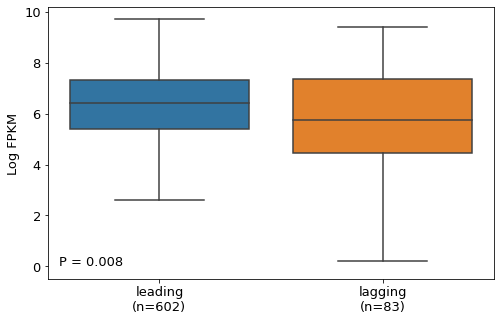

In [11]:
rep_strand_df = gene_table_ml[['rep_strand', 'fpkm']].dropna()
rep_strand_df['log_fpkm'] = np.log(rep_strand_df['fpkm'] + ETA)

# get an actual significance comparison here
leading = rep_strand_df[rep_strand_df['rep_strand'] == 'leading']['log_fpkm']
lagging = rep_strand_df[rep_strand_df['rep_strand'] == 'lagging']['log_fpkm']

t_stat, p_value = ttest_ind(leading, lagging, equal_var=False)

_, ax = plt.subplots(figsize=(8, 5))

sns.boxplot(x='rep_strand', y='log_fpkm',
            data=rep_strand_df, fliersize=0, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('')
ax.set_xticklabels([f"{lab.get_text()}\n(n={rep_strand_df[rep_strand_df['rep_strand'] == lab.get_text()].shape[0]})"
                       for lab in ax.get_xticklabels()])    
ax.set_ylabel('Log FPKM', fontsize=13)
ax.text(0.025, 0.05, f'P = {p_value:.3f}', fontsize=13, transform=ax.transAxes)

### Order in TU

In [12]:
def strongest_tu_for_gene(gene_row):
    
    # get TUs associated with gene
    tus_for_gene = [tu_id for tu_id, gene_ids in tu_to_genes.items() if gene_row.name in gene_ids]
    tus_for_gene_df = m_florum.tu_table.loc[tus_for_gene]
    if tus_for_gene_df.empty:
        return None
    
    # get the strongest TU specifically; previous work indicates that this helps
    def tss_to_rspm(tss):
        tss_df = m_florum.tss_table[m_florum.tss_table['tss'] == tss]
        if tss_df.empty:
            return None
        else:
            return tss_df.iloc[0, :]['rspm']
    tus_for_gene_df['rspm'] = tus_for_gene_df['tss'].apply(tss_to_rspm)
    gene_strong_tu = tus_for_gene_df.sort_values(by='rspm', ascending=False).iloc[0, :]
    
    return gene_strong_tu

In [13]:
def order_in_tu(gene_row):

    gene_strong_tu = strongest_tu_for_gene(gene_row)
    if gene_strong_tu is None:
        return None
    
    all_tu_gene_ids = [gid for gid in gene_strong_tu.gene_names.split(';') if 'peg' in gid]
    gene_df = m_florum.gene_table[m_florum.gene_table.index.isin(all_tu_gene_ids)]
    if gene_strong_tu.strand == 1:
        gene_starts = gene_df['left']
        sorted_genes, _ = list(zip(*sorted(zip(all_tu_gene_ids, gene_starts),
                                          key=lambda tup: tup[1])))
    else:
        gene_starts = gene_df['right']
        # reverse the sort on the reverse strand so the highest gene start is first (that's closest to TSS)
        sorted_genes, _ = list(zip(*sorted(zip(all_tu_gene_ids, gene_starts),
                                          key=lambda tup: tup[1], reverse=True)))

    gene_order_dict = {gene_id: i+1 for i, gene_id in enumerate(sorted_genes)}

    return gene_order_dict[gene_row.name]

In [14]:
gene_table_ml['tu_order'] = gene_table_ml.apply(order_in_tu, axis=1)
gene_table_ml.head()

NameError: name 'tu_to_genes' is not defined

In [ ]:
tu_rel_exps = {}

for tu_row in m_florum.tu_table.itertuples():
    tu_genes = tu_row.gene_names.split(';')
    tu_gene_df = m_florum.gene_table[m_florum.gene_table.index.isin(tu_genes)]
    if tu_gene_df.shape[0] > 1:
        
        if tu_row.strand == 1:
            sorted_gene_df = tu_gene_df.sort_values(by='left')
        else:
            sorted_gene_df = tu_gene_df.sort_values(by='right', ascending=False)
        
        tu_gene_exps_rel = np.log(np.array(sorted_gene_df['mean_fpkm']) + ETA) / \
            np.log(sorted_gene_df['mean_fpkm'][0] + ETA)
        
        for i, rel_exp in enumerate(tu_gene_exps_rel):
            if i in tu_rel_exps:
                tu_rel_exps[i].append(rel_exp)
            else:
                tu_rel_exps[i] = [rel_exp]
                
tu_rel_exps = {k: v for k, v in tu_rel_exps.items() if len(v) > 10}

In [ ]:
_, ax = plt.subplots(figsize=(15, 5))

ax.boxplot(list(tu_rel_exps.values()))
ax.set_xticklabels([f'{i+1}\n(n={len(vals)})' for i, vals in enumerate(tu_rel_exps.values())])
ax.set_xlabel('Order in TU', fontsize=13)
ax.set_ylabel('log[FPKM] Relative to 1st Gene', fontsize=13)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(bottom=0, top=3)
for i, vals in enumerate(tu_rel_exps.values()):
    med = np.median(vals)
    ax.text(i+1, med+0.05, f'{med:.2f}x', ha='center')

This comparison would be more informative at a TU-specific level (i.e. relative expression within multi-gene TUs)

### TSS to Translation Start Distance

In [ ]:
def tss_to_gene_start(gene_row):

    gene_strong_tu = strongest_tu_for_gene(gene_row)
    if gene_strong_tu is None:
        return None
        
    strand = gene_strong_tu.strand
    if strand == 1:
        tu_start = gene_strong_tu.left
        gene_start = gene_row.left
    else:
        tu_start = gene_strong_tu.right
        gene_start = gene_row.right

    return abs(tu_start - gene_start)

In [ ]:
gene_table_ml['tss_dist'] = gene_table_ml.apply(tss_to_gene_start, axis=1)
gene_table_ml.head()

In [ ]:
all_tss_dists = []
all_rel_exps_tss = []

for tu_row in m_florum.tu_table.itertuples():
    tu_genes = tu_row.gene_names.split(';')
    tu_gene_df = m_florum.gene_table[m_florum.gene_table.index.isin(tu_genes)]
    if tu_gene_df.shape[0] > 1:
        
        if tu_row.strand == 1:
            sorted_gene_df = tu_gene_df.sort_values(by='left')
            tss_dists = sorted_gene_df['left'].values - tu_row.tss
        else:
            sorted_gene_df = tu_gene_df.sort_values(by='right', ascending=False)
            tss_dists = tu_row.tss - sorted_gene_df['right']
        
        tu_gene_exps_rel = np.log(np.array(sorted_gene_df['mean_fpkm']) + ETA) / \
            np.log(sorted_gene_df['mean_fpkm'][0] + ETA)
        
        all_tss_dists += list(tss_dists[1:])
        all_rel_exps_tss += list(tu_gene_exps_rel[1:])

In [ ]:
_, ax = plt.subplots(figsize=(15, 5))

ax.scatter(all_tss_dists, all_rel_exps_tss)
ax.set_xlabel('Distance to TSS (bp)', fontsize=13)
ax.set_ylabel('log[FPKM] Relative to 1st Gene in TU', fontsize=13)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(0, 3)

This comparison would be more informative at a TU-specific level (i.e. relative expression within multi-gene TUs)

### Distance to Origin

In [ ]:
def dist_to_origin(gene_row):
    l, r = gene_row.left, gene_row.right
    seq_max = len(m_florum.sequence)
    return np.min([
        genome_point_to_point(m_florum.origin[0], l, seq_max),
        genome_point_to_point(m_florum.origin[0], r, seq_max),
        genome_point_to_point(m_florum.origin[1], l, seq_max),
        genome_point_to_point(m_florum.origin[1], r, seq_max)
    ])

In [ ]:
gene_table_ml['origin_dist'] = gene_table_ml.apply(dist_to_origin, axis=1)
gene_table_ml.head()

In [ ]:
origin_dist_df = gene_table_ml[['origin_dist', 'mean_fpkm', 'tu_order', 'rep_strand']].dropna()
origin_dist_df['log_fpkm'] = np.log(origin_dist_df['mean_fpkm'] + ETA)
origin_dist_df = origin_dist_df[origin_dist_df['tu_order'] == 1]

_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='origin_dist', y='log_fpkm', hue='rep_strand', data=origin_dist_df, ax=ax,
               hue_order=['lagging', 'leading'])
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('ORI to Gene Start (bp)', fontsize=13)
ax.set_ylabel('log[FPKM]', fontsize=13)

### 5'-UTR

#### Length

In [ ]:
def utr_len(gene_row):

    gene_strong_tu = strongest_tu_for_gene(gene_row)
    if gene_strong_tu is None:
        return None
    
    all_tu_gene_ids = [gid for gid in gene_strong_tu.gene_names.split(';') if 'peg' in gid]
    gene_df = m_florum.gene_table[m_florum.gene_table.index.isin(all_tu_gene_ids)]

    if gene_strong_tu.strand == 1:
        gene_starts = gene_df['left']
        _, sorted_starts = list(zip(*sorted(zip(all_tu_gene_ids, gene_starts),
                                          key=lambda tup: tup[1])))
        utr_len = sorted_starts[0] - gene_strong_tu.tss
    else:
        gene_starts = gene_df['right']
        # reverse the sort on the reverse strand so the highest gene start is first (that's closest to TSS)
        _, sorted_starts = list(zip(*sorted(zip(all_tu_gene_ids, gene_starts),
                                          key=lambda tup: tup[1], reverse=True)))
        utr_len = gene_strong_tu.tss - sorted_starts[0]

    return utr_len

In [ ]:
gene_table_ml['utr_len'] = gene_table_ml.apply(utr_len, axis=1)
gene_table_ml.head()

In [ ]:
utr_len_df = gene_table_ml[['utr_len', 'mean_fpkm']].dropna()
utr_len_df['log_fpkm'] = np.log(utr_len_df['mean_fpkm'] + ETA)
utr_len_df = utr_len_df[utr_len_df['utr_len'] > 0]

_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='utr_len', y='log_fpkm', data=utr_len_df, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("5' UTR Len (bp) ", fontsize=13)
ax.set_ylabel('log[FPKM]', fontsize=13)

#### GC Content

In [ ]:
def utr_gc(gene_row):

    gene_strong_tu = strongest_tu_for_gene(gene_row)
    if gene_strong_tu is None:
        return None
    
    all_tu_gene_ids = [gid for gid in gene_strong_tu.gene_names.split(';') if 'peg' in gid]
    gene_df = m_florum.gene_table[m_florum.gene_table.index.isin(all_tu_gene_ids)]
    if gene_strong_tu.strand == 1:
        gene_starts = gene_df['left']
        _, sorted_starts = list(zip(*sorted(zip(all_tu_gene_ids, gene_starts),
                                          key=lambda tup: tup[1])))
        utr_left, utr_right = gene_strong_tu.tss, sorted_starts[0]
    else:
        gene_starts = gene_df['right']
        # reverse the sort on the reverse strand so the highest gene start is first (that's closest to TSS)
        _, sorted_starts = list(zip(*sorted(zip(all_tu_gene_ids, gene_starts),
                                          key=lambda tup: tup[1], reverse=True)))

        utr_left, utr_right = sorted_starts[0], gene_strong_tu.tss
        
    # handle weird case with TU_052 and peg.78...double check data later
    if utr_left > utr_right:
        return None
    else:
        return GC(m_florum.get_sequence(utr_left, utr_right, gene_strong_tu.strand))

In [ ]:
gene_table_ml['utr_gc'] = gene_table_ml.apply(utr_gc, axis=1)
gene_table_ml.head()

In [ ]:
utr_gc_df = gene_table_ml[['utr_gc', 'mean_fpkm']].dropna()
utr_gc_df['log_fpkm'] = np.log(utr_gc_df['mean_fpkm'] + ETA)

_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='utr_gc', y='log_fpkm', data=utr_gc_df, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("5' UTR GC %", fontsize=13)
ax.set_ylabel('log[FPKM]', fontsize=13)

### Transcript Length

In [ ]:
def tu_len(gene_row):

    gene_strong_tu = strongest_tu_for_gene(gene_row)
    if gene_strong_tu is None:
        return None
    else:
        return gene_strong_tu.right - gene_strong_tu.left

In [ ]:
gene_table_ml['tu_len'] = gene_table_ml.apply(tu_len, axis=1)
gene_table_ml.head()

In [ ]:
tu_len_df = gene_table_ml[['tu_len', 'mean_fpkm']].dropna()
tu_len_df['log_fpkm'] = np.log(tu_len_df['mean_fpkm'] + ETA)

_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='tu_len', y='log_fpkm', data=tu_len_df, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("TU Len (bp) ", fontsize=13)
ax.set_ylabel('log[FPKM]', fontsize=13)

### TU GC Content

In [ ]:
def tu_gc(gene_row):

    gene_strong_tu = strongest_tu_for_gene(gene_row)
    if gene_strong_tu is None:
        return None
    else:
        return GC(m_florum.get_feature_sequence(gene_strong_tu))

In [ ]:
gene_table_ml['tu_gc'] = gene_table_ml.apply(tu_gc, axis=1)
gene_table_ml.head()

In [ ]:
tu_gc_df = gene_table_ml[['tu_gc', 'mean_fpkm']].dropna()
tu_gc_df['log_fpkm'] = np.log(tu_gc_df['mean_fpkm'] + ETA)

_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='tu_gc', y='log_fpkm', data=tu_gc_df, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("TU GC %", fontsize=13)
ax.set_ylabel('log[FPKM]', fontsize=13)

### Genome Location

Meant to be a crude approximation of the chromosome interacting domains discovered in M. pneumo (Cell Systems 2019)

They discovered 44 CIDs; let's replicate that by just splitting the genome evenly into 44 pieces (yes very crude)

Also to capture the circularity, do this in the sin of the radians

In [ ]:
N_CID_BINS = 44

def cid(gene_row):

    gene_strong_tu = strongest_tu_for_gene(gene_row)
    if gene_strong_tu is None:
        return None
    
    if gene_strong_tu.strand == 1:
        tu_start = gene_strong_tu.left
    else:
        tu_start = gene_strong_tu.right
        
    cid = np.floor(tu_start / len(m_florum.sequence) * N_CID_BINS)

    return cid

In [ ]:
gene_table_ml['cid'] = gene_table_ml.apply(cid, axis=1)
gene_table_ml['cid_sin'] = gene_table_ml['cid'].apply(
    lambda cid: np.round(np.sin(2 * np.pi * cid / N_CID_BINS), 4))
gene_table_ml['cid_cos'] = gene_table_ml['cid'].apply(
    lambda cid: np.round(np.cos(2 * np.pi * cid / N_CID_BINS), 4))
gene_table_ml['cid_cat'] = gene_table_ml['cid'].apply(str)
gene_table_ml = gene_table_ml.drop(columns=['cid'])
gene_table_ml.plot.scatter('cid_sin','cid_cos').set_aspect('equal')

In [ ]:
cid_df = gene_table_ml[['cid_sin', 'cid_cos', 'cid_cat', 'mean_fpkm']].dropna()
cid_df['log_fpkm'] = np.log(cid_df['mean_fpkm'] + ETA)
cid_df['sincos'] = cid_df.apply(lambda row: str(row.cid_sin) + str(row.cid_cos), axis=1)

_, ax = plt.subplots(figsize=(15, 7))
sns.boxplot(x='cid_cat', y='log_fpkm', data=cid_df, ax=ax, dodge=True)
ax.tick_params(axis='both', labelsize=13)
ax.tick_params(axis='x', rotation=90)
ax.set_xlabel("CID", fontsize=13)
ax.set_ylabel('log[FPKM]', fontsize=13)

#### ANOVA

In [ ]:
exp_groups = []
for sincos, sincos_df in cid_df.groupby('sincos'):
    exp_groups.append(sincos_df['log_fpkm'])
    
f, p = f_oneway(*exp_groups)

print(f'P value of ANOVA: {p:.2E}')

### -10 Box

Let's try something here; can we make these into categories?

#### -10 Box Sequence

In [ ]:
def box_10_seq(gene_row):

    gene_strong_tu = strongest_tu_for_gene(gene_row)
    if gene_strong_tu is None:
        return None
    
    if not pd.isna(gene_strong_tu.box_10_left):
        box_10_seq = str(m_florum.get_sequence(gene_strong_tu.box_10_left,
                                           gene_strong_tu.box_10_right,
                                           gene_strong_tu.strand))
    else:
        box_10_seq = None

    return box_10_seq

In [ ]:
gene_table_ml['box_10_seq'] = gene_table_ml.apply(box_10_seq, axis=1)
gene_table_ml.head()

In [ ]:
box_df = gene_table_ml[['box_10_seq', 'mean_fpkm']].dropna()
box_df['log_fpkm'] = np.log(box_df['mean_fpkm'] + ETA)

box_10_dfs = []

for _, b10seq_df in box_df.groupby('box_10_seq'):
    if b10seq_df.shape[0] > 5:
        box_10_dfs.append(b10seq_df)
        
box_10_dfs = sorted(box_10_dfs, key=lambda df: df['log_fpkm'].median(), reverse=True)
box_10_df = pd.concat(box_10_dfs)

_, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x='box_10_seq', y='log_fpkm', data=box_10_df, fliersize=0, ax=ax)
sns.swarmplot(x='box_10_seq', y='log_fpkm', data=box_10_df, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('')
ax.set_ylabel('log[FPKM]', fontsize=13)
ax.set_xticklabels([f"{lab.get_text()}\n(n={box_10_df[box_10_df['box_10_seq'] == lab.get_text()].shape[0]})"
                   for lab in ax.get_xticklabels()])
ax.set_title(f"-10 Box Sequence (n={len(box_df['box_10_seq'].unique())}; 11 with >5 genes shown)", fontsize=14)

#### -10 Box Distance to TSS

In [ ]:
def box_10_dist(gene_row):

    gene_strong_tu = strongest_tu_for_gene(gene_row)
    if gene_strong_tu is None:
        return None
    
    if not pd.isna(gene_strong_tu.box_10_left):
        box_10_tss_dist = int(min(
            abs(gene_strong_tu.box_10_left - gene_strong_tu.tss),
            abs(gene_strong_tu.box_10_right - gene_strong_tu.tss)
        ))
    else:
        box_10_tss_dist = None

    return box_10_tss_dist

In [ ]:
gene_table_ml['box_10_dist'] = gene_table_ml.apply(box_10_dist, axis=1)
gene_table_ml.head()

In [ ]:
box_dist_df = gene_table_ml[['box_10_dist', 'mean_fpkm']].dropna()
box_dist_df['log_fpkm'] = np.log(box_dist_df['mean_fpkm'] + ETA)
box_dist_df = box_dist_df[box_dist_df['box_10_dist'] < 9]

_, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x='box_10_dist', y='log_fpkm', data=box_dist_df, fliersize=0, ax=ax)
sns.swarmplot(x='box_10_dist', y='log_fpkm', data=box_dist_df, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('-10 Box Distance to TSS (bp)', fontsize=14)
ax.set_xticklabels([
    f"{int(float(lab.get_text()))}\n (n={box_dist_df[box_dist_df['box_10_dist'] == float(lab.get_text())].shape[0]})"
    for lab in ax.get_xticklabels()
])
ax.set_ylabel('log[FPKM]', fontsize=14)

#### -10 Box Motif Strength

In [ ]:
# let's recreate the -10 box motif using all known TUs
box_10_seqs = []

for tu_row in m_florum.tu_table.itertuples():
    if not pd.isna(tu_row.box_10_left):
        box_10_seq = m_florum.get_sequence(tu_row.box_10_left,
                                           tu_row.box_10_right,
                                           tu_row.strand)
        box_10_seqs.append(box_10_seq)
        
box_10_motif = create_motif(box_10_seqs)
box_10_pssm = box_10_motif.pssm

In [ ]:
with open('temp.fa', 'w') as file_motif:
    for i, seq in enumerate(box_10_seqs):
        file_motif.write(f'>{i}\n{str(seq)}\n')
        
with open("temp.fa") as file_motif:
    seqs = read_seq_data(file_motif, alphabet=unambiguous_dna_alphabet)
    
os.remove('temp.fa')

logodata = LogoData.from_seqs(seqs)
logooptions = LogoOptions(
    title='-10 Box Motif',
    show_fineprint=False
)
logoformat = LogoFormat(logodata, logooptions)
png = png_formatter(logodata, logoformat)
Image(png)

In [ ]:
def box_10_score(gene_row):

    gene_strong_tu = strongest_tu_for_gene(gene_row)
    if gene_strong_tu is None:
        return None
    
    if not pd.isna(gene_strong_tu.box_10_left):
        box_10_seq = m_florum.get_sequence(gene_strong_tu.box_10_left,
                                          gene_strong_tu.box_10_right,
                                          gene_strong_tu.strand)
        box_10_score = score_motif_match(box_10_seq, box_10_pssm)
    else:
        box_10_score = None

    return box_10_score

In [ ]:
gene_table_ml['box_10_score'] = gene_table_ml.apply(box_10_score, axis=1)
gene_table_ml.head()

In [ ]:
box_10_score_df = gene_table_ml[['box_10_score', 'mean_fpkm']].dropna()
box_10_score_df['log_fpkm'] = np.log(box_10_score_df['mean_fpkm'] + ETA)

_, ax = plt.subplots()
sns.scatterplot(x='box_10_score', y='log_fpkm', data=box_10_score_df, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('-10 Box Motif Score', fontsize=14)
ax.set_ylabel('log[FPKM]', fontsize=14)

#### Extended -10 Box AT Content

AT content of 3 bp upstream of -10 box

In [ ]:
def ext_10_at(gene_row):

    gene_strong_tu = strongest_tu_for_gene(gene_row)
    if gene_strong_tu is None:
        return None
    
    if not pd.isna(gene_strong_tu.box_10_left):
        if gene_strong_tu.strand == 1:
            ext_10_seq = str(m_florum.get_sequence(gene_strong_tu.box_10_left - 3,
                                           gene_strong_tu.box_10_left - 1,
                                           gene_strong_tu.strand))
        else:
            ext_10_seq = str(m_florum.get_sequence(gene_strong_tu.box_10_right + 1,
                                           gene_strong_tu.box_10_right + 3,
                                           gene_strong_tu.strand))
        ext_10_at = np.round((100 - GC(ext_10_seq)) / 100, decimals=2)
    else:
        ext_10_at = None

    return ext_10_at

In [ ]:
gene_table_ml['ext_10_at'] = gene_table_ml.apply(ext_10_at, axis=1)
gene_table_ml.head()

In [ ]:
ext_10_at_df = gene_table_ml[['ext_10_at', 'mean_fpkm']].dropna()
ext_10_at_df['log_fpkm'] = np.log(ext_10_at_df['mean_fpkm'] + ETA)

_, ax = plt.subplots()
sns.boxplot(x='ext_10_at', y='log_fpkm', data=ext_10_at_df, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('Extended -10 Box AT Content', fontsize=14)
ax.set_ylabel('log[FPKM]', fontsize=14)
ax.set_xticklabels([
    f"{float(lab.get_text())}\n (n={ext_10_at_df[ext_10_at_df['ext_10_at'] == float(lab.get_text())].shape[0]})"
    for lab in ax.get_xticklabels()
])

### CRE Sequence

Let's try this again with the CRE (-4 to +2, core RNAP binding site)

In [ ]:
def cre_seq(gene_row):

    gene_strong_tu = strongest_tu_for_gene(gene_row)
    if gene_strong_tu is None:
        return None
    
    if not pd.isna(gene_strong_tu.tss):
        if gene_strong_tu.strand == 1:
            cre_seq = str(m_florum.get_sequence(gene_strong_tu.tss - 4,
                                               gene_strong_tu.tss + 1,
                                               gene_strong_tu.strand))
        else:
            cre_seq = str(m_florum.get_sequence(gene_strong_tu.tss - 1,
                                               gene_strong_tu.tss + 4,
                                               gene_strong_tu.strand))
    else:
        cre_seq = None

    return cre_seq

In [ ]:
gene_table_ml['cre_seq'] = gene_table_ml.apply(cre_seq, axis=1)
gene_table_ml.head()

In [ ]:
cre_df = gene_table_ml[['cre_seq', 'mean_fpkm']].dropna()

_, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x='cre_seq', y='mean_fpkm', data=cre_df, fliersize=0, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('Mean FPKM', fontsize=13)
ax.set_title(f"CRE Sequence (n={len(cre_df['cre_seq'].unique())})", fontsize=14)

#### TSS Nucleotide

In [ ]:
def tss_base(gene_row):

    gene_strong_tu = strongest_tu_for_gene(gene_row)
    if gene_strong_tu is None:
        return None
    
    if not pd.isna(gene_strong_tu.tss):
        tss_base = str(m_florum.get_sequence(
            gene_strong_tu.tss,
            gene_strong_tu.tss,
            gene_strong_tu.strand)
                      )
    else:
        tss_base = None

    return tss_base

In [ ]:
gene_table_ml['tss_base'] = gene_table_ml.apply(tss_base, axis=1)
gene_table_ml.head()

In [ ]:
tss_base_df = gene_table_ml[['tss_base', 'mean_fpkm']].dropna()
tss_base_df['log_fpkm'] = np.log(tss_base_df['mean_fpkm'] + ETA)

_, ax = plt.subplots()
sns.boxplot(x='tss_base', y='log_fpkm', data=tss_base_df, fliersize=0, ax=ax)
sns.swarmplot(x='tss_base', y='log_fpkm', data=tss_base_df, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('')
ax.set_ylabel('log[FPKM]', fontsize=13)
ax.set_title(f"TSS Base", fontsize=14)
ax.set_xticklabels([
    f"{lab.get_text()}\n (n={tss_base_df[tss_base_df['tss_base'] == lab.get_text()].shape[0]})"
    for lab in ax.get_xticklabels()
])

#### TSS Dinucleotide (-1)

In [ ]:
def tss_dinuc(gene_row):

    gene_strong_tu = strongest_tu_for_gene(gene_row)
    if gene_strong_tu is None:
        return None
    
    if not pd.isna(gene_strong_tu.tss):
        if gene_strong_tu.strand == 1:
            tss_dinuc = str(m_florum.get_sequence(
                gene_strong_tu.tss-1,
                gene_strong_tu.tss,
                gene_strong_tu.strand)
                          )
        else:
            tss_dinuc = str(m_florum.get_sequence(
                gene_strong_tu.tss,
                gene_strong_tu.tss+1,
                gene_strong_tu.strand)
                          )
    else:
        tss_dinuc = None

    return tss_dinuc

In [ ]:
gene_table_ml['tss_dinuc'] = gene_table_ml.apply(tss_dinuc, axis=1)
gene_table_ml.head()

In [ ]:
tss_dinuc_df = gene_table_ml[['tss_dinuc', 'mean_fpkm']].dropna()
tss_dinuc_df['log_fpkm'] = np.log(tss_dinuc_df['mean_fpkm'] + ETA)

_, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='tss_dinuc', y='log_fpkm', data=tss_dinuc_df, fliersize=0, ax=ax)
sns.swarmplot(x='tss_dinuc', y='log_fpkm', data=tss_dinuc_df, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('')
ax.set_ylabel('log[FPKM]', fontsize=13)
ax.set_title(f"TSS Dinucleotide (-1/+1)", fontsize=14)
ax.set_xticklabels([
    f"{lab.get_text()}\n (n={tss_dinuc_df[tss_dinuc_df['tss_dinuc'] == lab.get_text()].shape[0]})"
    for lab in ax.get_xticklabels()
]);

#### TSS Dinucleotide (+1)

In [ ]:
def tss_dinuc_plus(gene_row):

    gene_strong_tu = strongest_tu_for_gene(gene_row)
    if gene_strong_tu is None:
        return None
    
    if not pd.isna(gene_strong_tu.tss):
        if gene_strong_tu.strand == 1:
            tss_dinuc = str(m_florum.get_sequence(
                gene_strong_tu.tss,
                gene_strong_tu.tss+1,
                gene_strong_tu.strand)
                          )
        else:
            tss_dinuc = str(m_florum.get_sequence(
                gene_strong_tu.tss-1,
                gene_strong_tu.tss,
                gene_strong_tu.strand)
                          )
    else:
        tss_dinuc = None

    return tss_dinuc

In [ ]:
gene_table_ml['tss_dinuc_plus'] = gene_table_ml.apply(tss_dinuc_plus, axis=1)
gene_table_ml.head()

In [ ]:
tss_dinucp_df = gene_table_ml[['tss_dinuc_plus', 'mean_fpkm']].dropna()
tss_dinucp_df['log_fpkm'] = np.log(tss_dinucp_df['mean_fpkm'] + ETA)

_, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='tss_dinuc_plus', y='log_fpkm', data=tss_dinucp_df, fliersize=0, ax=ax)
sns.swarmplot(x='tss_dinuc_plus', y='log_fpkm', data=tss_dinucp_df, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('')
ax.set_ylabel('log[FPKM]', fontsize=13)
ax.set_title(f"TSS Dinucleotide (+1/+2)", fontsize=14)
ax.set_xticklabels([
    f"{lab.get_text()}\n (n={tss_dinucp_df[tss_dinucp_df['tss_dinuc_plus'] == lab.get_text()].shape[0]})"
    for lab in ax.get_xticklabels()
]);

### Diverging Promoters

Find and visualize instances where TUs are "back-to-back" (i.e. their TSSes are next to each other, going opposite ways)

In [ ]:
sorted_tu_table = m_florum.tu_table.copy().sort_values(by='tss')

i = 0

ratios = []
rand_ratios = []

while i < sorted_tu_table.shape[0] - 1:
    
    tu_row_a = sorted_tu_table.iloc[i, :]
    tu_row_b = sorted_tu_table.iloc[i+1, :]
    
    # this is the only way to have back-to-back, if we go along the positive strand
    if tu_row_a.strand == -1 and tu_row_b.strand == 1:

        tu_row_a_genes = tu_row_a.gene_names.split(';')
        tu_a_gene_df = m_florum.gene_table[m_florum.gene_table.index.isin(tu_row_a_genes)]
        tu_row_b_genes = tu_row_b.gene_names.split(';')
        tu_b_gene_df = m_florum.gene_table[m_florum.gene_table.index.isin(tu_row_b_genes)]
        
        if not tu_a_gene_df.empty and not tu_b_gene_df.empty:
            tu_a_exp = np.log(tu_a_gene_df.sort_values(by='right', ascending=False).iloc[0, :]['mean_fpkm'] + ETA)
            tu_b_exp = np.log(tu_b_gene_df.sort_values(by='left').iloc[0, :]['mean_fpkm'] + ETA)
        
            ratio = min(tu_a_exp, tu_b_exp) / max(tu_a_exp, tu_b_exp)
            ratios.append(ratio)
            rand_exps = np.log(np.random.choice(m_florum.gene_table['mean_fpkm'], size=2) + ETA)
            rand_ratio = min(rand_exps) / max(rand_exps)
            rand_ratios.append(rand_ratio)
            
            i += 2
        else:
            i += 1
    else:
        i += 1
        
diverge_df = pd.DataFrame(data={'log[FPKM] Ratio': ratios + rand_ratios,
                               'source': ['diverging'] * len(ratios) + ['random'] * len(rand_ratios)})

_, ax = plt.subplots()

t_stat, p_value = ttest_ind(ratios, rand_ratios, equal_var=False)

sns.boxplot(x='source', y='log[FPKM] Ratio', data=diverge_df, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('log[FPKM] Ratio', fontsize=13)
ax.tick_params(axis='both', labelsize=13)
ax.set_title('Effect of Diverging TUs on 1st Gene Expression', fontsize=14)
ax.text(0.8, 0.2, f'P={p_value:.3f}', transform=ax.transAxes, fontsize=13)

In [ ]:
_, ax = plt.subplots()

t_stat, p_value = ttest_ind(ratios, rand_ratios, equal_var=False)

sns.boxplot(x='source', y='log[FPKM] Ratio', data=diverge_df, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('log[FPKM] Ratio', fontsize=13)
ax.tick_params(axis='both', labelsize=13)
ax.set_title('Effect of Diverging TUs on 1st Gene Expression', fontsize=14)
ax.text(0.8, 0.2, f'P={p_value:.3f}', transform=ax.transAxes, fontsize=13)

### Finalize Feature Matrices

In [ ]:
X = gene_table_ml.drop(columns=['left', 'right', 'strand', 'KO', 'category', 'subcategory', 'subsubcategory',
                               'product_name', 'name', 'sd_fpkm']).dropna()
y = X['mean_fpkm']
X = X.drop(columns=['mean_fpkm'])

X_go_all = pd.get_dummies(X.copy())
X_no_cre = pd.get_dummies(X.copy().drop(columns=['cre_seq']))
X_no_box10 = pd.get_dummies(X.copy().drop(columns=['box_10_seq']))
X_no_seqs = pd.get_dummies(X.copy().drop(columns=['cre_seq', 'box_10_seq']))

Xy_to_try_go = {
    'all': (X_go_all, y),
    'no_cre': (X_no_cre, y),
    'no_box10': (X_no_box10, y),
    'no_seqs': (X_no_seqs, y)
}

### Set Aside Lockbox Data

In [ ]:
Xy_train_to_use_go = {}
Xy_lockbox_to_use_go = {}

for name, (X, y) in Xy_to_try_go.items():
    if X.shape[0] > 500:
        test_size = 0.1
    else:
        test_size = 0.2
    X_train, X_lockbox, y_train, y_lockbox = train_test_split(X, y, test_size=test_size, random_state=42)
    Xy_train_to_use_go[name] = (X_train, y_train)
    Xy_lockbox_to_use_go[name] = (X_lockbox, y_lockbox)

# Initial Model Profiling - Genome Organization

In [ ]:
initial_profile_df_go = pd.DataFrame(
    columns=['model', 'xy', 'train_r2', 'val_r2']
)

N_CV = 5

for model_name, model in models_to_try.items():
    for Xy_name, (X_train_raw, y_train_raw) in Xy_train_to_use_go.items():
        
        X_train_norm = StandardScaler().fit_transform(X_train_raw)
        y_train_norm = StandardScaler().fit_transform(y_train_raw.values.reshape(-1, 1))
        y_train_log = np.log(y_train_raw + ETA)
        y_train_norm_log = StandardScaler().fit_transform(y_train_log.values.reshape(-1, 1))
        
        X_list = [('X_raw', X_train_raw), ('X_norm', X_train_norm)]
        y_list = [('y_raw', y_train_raw), ('y_norm', y_train_norm),
                 ('y_log', y_train_log), ('y_norm_log', y_train_norm_log)]
        
        Xy_final = {}
        for (X_lab, X_mat), (y_lab, y_mat) in product(X_list, y_list):
            Xy_lab_final = f'{Xy_name}__{X_lab}__{y_lab}'
            Xy_final[Xy_lab_final] = (X_mat, y_mat)
            
        for Xy_full_name, (X_to_use, y_to_use) in Xy_final.items():

            print(f'{model_name}: {Xy_full_name}')

            cv_result = cross_validate(
                model,
                X_to_use,
                y=y_to_use,
                cv=N_CV,
                scoring='r2',
                return_train_score=True,
                verbose=1,
                n_jobs=N_CV
            )

            sub_result_df = pd.DataFrame(
                data={
                    'model': [model_name] * N_CV,
                    'xy': [Xy_full_name] * N_CV,
                    'train_r2': cv_result['train_score'],
                    'val_r2': cv_result['test_score']
                }
            )

            initial_profile_df_go = initial_profile_df_go.append(sub_result_df)

In [ ]:
_, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x='model', y='train_r2', data=initial_profile_df_go, hue='xy', dodge=True, ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
ax.set_xlabel('')
ax.set_ylabel('Training R-Squared')
ax.set_ylim(bottom=0, top=1)

In [ ]:
to_plot_df = initial_profile_df_go[initial_profile_df_go['model'] == 'RF']

_, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x='model', y='val_r2', data=initial_profile_df_go, hue='xy', dodge=True, ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
ax.set_xlabel('')
ax.set_ylabel('Validation R-Squared')
ax.set_ylim(0, 0.5)

# Feature Importances - Genome Organization

In [ ]:
X_fi_go, y_fi_go = Xy_train_to_use_go['no_cre']

X_fi_go = pd.DataFrame(StandardScaler().fit_transform(X_fi_go), columns=X_fi_go.columns, index=X_fi_go.index)
y_fi_go = np.log(y_fi_go + ETA)

X_fi_go_train, X_fi_go_val, y_fi_go_train, y_fi_go_val = train_test_split(
    X_fi_go, y_fi_go, test_size=0.15, random_state=35)

In [ ]:
rf_fi_go = models_to_try['RF'].fit(X_fi_go_train, y_fi_go_train)
explainer = shap.TreeExplainer(rf_fi_go)
shap_values = explainer.shap_values(X_fi_go_val)

In [ ]:
shap.summary_plot(shap_values, X_fi_go_val)

# Hyperoptimization - Genome Organization

In [ ]:
X_go_hyperopt, y_go_hyperopt = Xy_train_to_use_go['no_cre']

X_go_hyperopt = pd.DataFrame(
    StandardScaler().fit_transform(X_go_hyperopt), columns=X_go_hyperopt.columns, index=X_go_hyperopt.index)
y_go_hyperopt = np.log(y_go_hyperopt + ETA)

hyperopt_XY_go = {
    'no_cre': (X_go_hyperopt, y_go_hyperopt)
}

In [ ]:
hyperopt_models = {
    'RF': {
        'model': RandomForestRegressor(),
        'param_dists': {
            'n_estimators': [25, 50, 100, 250],
            'max_depth': np.arange(2, 20)
        }
    }
}

In [ ]:
hyperopt_results = {}

for model_name, model_hyperopt_dict in hyperopt_models.items():

    hyperopt_results[model_name] = {}
    
    for X_name, (X, y) in hyperopt_XY_go.items():
        print(f'{model_name}: {X_name}')

        random_search_hyperopt = RandomizedSearchCV(
            model_hyperopt_dict['model'],
            model_hyperopt_dict['param_dists'],
            n_iter=25,
            scoring='r2',
            n_jobs=4,
            cv=5,
            verbose=3,
            return_train_score=True
        )

        random_search_hyperopt.fit(X, y)

        hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
            by='mean_test_score',
            ascending=False
        )
        hyperopt_results[model_name][X_name] = hyperopt_results_df

In [ ]:
hyperopt_results['RF']['no_cre'].iloc[:10, :][['params', 'mean_train_score', 'mean_test_score']]

# TATAAT Group Variance

## TSS Base

In [ ]:
tata_df = gene_table_ml[gene_table_ml['box_10_seq'] == 'TATAAT'].copy()
tata_df['log_fpkm'] = np.log(tata_df['mean_fpkm'] + ETA)
# tata_df = tata_df[tata_df['tu_order'] == 1]

_, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x='tss_base', y='log_fpkm', data=tata_df, fliersize=0, ax=ax)
sns.swarmplot(x='tss_base', y='log_fpkm', data=tata_df, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('')
ax.set_ylabel('log[FPKM]', fontsize=13)
ax.set_xticklabels([f"{lab.get_text()}\n(n={tata_df[tata_df['tss_base'] == lab.get_text()].shape[0]})"
                   for lab in ax.get_xticklabels()])
ax.set_title('TSS Bases within TATAAT -10 Box Group', fontsize=14)

## High-Expressed TATA/TSS A Genes

In [ ]:
tata_a_df = tata_df[tata_df['tss_base'] == 'A']
tata_a_df['length'] = (tata_a_df['right'] - tata_a_df['left']).copy()

tata_a_df[tata_a_df['log_fpkm'] > 8].sort_values(by='log_fpkm', ascending=False)

- Many involved in central processes (central carbon metabolism, ribosome)
- almost all on leading strand

## Low-Expressed TATA/TSS A Genes

In [ ]:
tata_a_df[tata_a_df['log_fpkm'] < 4].sort_values(by='log_fpkm')

## Origin Distance

In [ ]:
_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='origin_dist', y='log_fpkm', data=tata_a_df, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('ORI to Gene Start (bp)', fontsize=13)
ax.set_ylabel('log[FPKM]', fontsize=13)
ax.set_title('ORI to Gene Start for TATAAT/TSS A Group', fontsize=14)

## TU GC Content

In [ ]:
_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='tu_gc', y='log_fpkm', data=tata_a_df, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('TU GC %', fontsize=13)
ax.set_ylabel('log[FPKM]', fontsize=13)
ax.set_title('TU GC Content for TATAAT/TSS A Group', fontsize=14)

## 5'-UTR Length

In [ ]:
_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='utr_len', y='log_fpkm', data=tata_a_df, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("5' UTR Len(bp)", fontsize=13)
ax.set_ylabel('log[FPKM]', fontsize=13)
ax.set_title("5' UTR Length for TATAAT/TSS A Group", fontsize=14)

## TSS Dinucleotide

In [ ]:
_, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x='tss_dinuc', y='log_fpkm', data=tata_a_df, fliersize=0, ax=ax)
sns.swarmplot(x='tss_dinuc', y='log_fpkm', data=tata_a_df, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('')
ax.set_ylabel('log[FPKM]', fontsize=13)
ax.set_xticklabels([f"{lab.get_text()}\n(n={tata_a_df[tata_a_df['tss_dinuc'] == lab.get_text()].shape[0]})"
                   for lab in ax.get_xticklabels()])
ax.set_title('TSS Dinucleotide (-1/+1) within TATAAT -10 Box Group', fontsize=14)

In [ ]:
_, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x='tss_dinuc_plus', y='log_fpkm', data=tata_a_df, fliersize=0, ax=ax)
sns.swarmplot(x='tss_dinuc_plus', y='log_fpkm', data=tata_a_df, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('')
ax.set_ylabel('log[FPKM]', fontsize=13)
ax.set_xticklabels([f"{lab.get_text()}\n(n={tata_a_df[tata_a_df['tss_dinuc_plus'] == lab.get_text()].shape[0]})"
                   for lab in ax.get_xticklabels()])
ax.set_title('TSS Dinucleotide (+1/+2) within TATAAT -10 Box Group', fontsize=14)

## Genome Location

In [ ]:
tata_a_df['cid'] = tata_a_df.apply(cid, axis=1)

_, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x='cid', y='log_fpkm', data=tata_a_df, fliersize=0, ax=ax)
sns.swarmplot(x='cid', y='log_fpkm', data=tata_a_df, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('log[FPKM]', fontsize=13)
ax.set_xticklabels([f"{lab.get_text()} (n={tata_a_df[tata_a_df['cid'] == lab.get_text()].shape[0]})"
                   for lab in ax.get_xticklabels()])
ax.set_title('CID within TATAAT -10 Box Group', fontsize=14)

## Modeling Expression within TATA/TSS A Group

### Initial Model Profiling

In [ ]:
X_no_cre_copy = Xy_to_try_go['no_cre'][0].copy()
y_no_cre_copy = Xy_to_try_go['no_cre'][1].copy()

X_tata_tss_a = X_no_cre_copy[
    X_no_cre_copy.index.isin(tata_a_df.index)
].drop(columns=[col for col in X_no_cre_copy.columns if ('tss_base' in col) or
                (col == 'box_10_score') or ('box_10_seq' in col)])
y_tata_tss_a = y_no_cre_copy[
    X_no_cre_copy.index.isin(tata_a_df.index)
]

Xy_to_try_tata = {
    'tata': (X_tata_tss_a, y_tata_tss_a)
}

Xy_train_to_use_tata = {}
Xy_lockbox_to_use_tata = {}

for name, (X, y) in Xy_to_try_tata.items():
    if X.shape[0] > 500:
        test_size = 0.1
    else:
        test_size = 0.2
    X_train, X_lockbox, y_train, y_lockbox = train_test_split(X, y, test_size=test_size, random_state=42)
    Xy_train_to_use_tata[name] = (X_train, y_train)
    Xy_lockbox_to_use_tata[name] = (X_lockbox, y_lockbox)

models_to_try_tata = {
    'RF': models_to_try['RF']
}

In [ ]:
initial_profile_df_tata = pd.DataFrame(
    columns=['model', 'xy', 'train_r2', 'val_r2']
)

N_CV = 5

for model_name, model in models_to_try_tata.items():
    for Xy_name, (X_train_raw, y_train_raw) in Xy_train_to_use_tata.items():
        
        X_train_norm = StandardScaler().fit_transform(X_train_raw)
        y_train_norm = StandardScaler().fit_transform(y_train_raw.values.reshape(-1, 1))
        y_train_log = np.log(y_train_raw + ETA)
        y_train_norm_log = StandardScaler().fit_transform(y_train_log.values.reshape(-1, 1))
        
        X_list = [('X_raw', X_train_raw), ('X_norm', X_train_norm)]
        y_list = [('y_raw', y_train_raw), ('y_norm', y_train_norm),
                 ('y_log', y_train_log), ('y_norm_log', y_train_norm_log)]
        
        Xy_final = {}
        for (X_lab, X_mat), (y_lab, y_mat) in product(X_list, y_list):
            Xy_lab_final = f'{Xy_name}__{X_lab}__{y_lab}'
            Xy_final[Xy_lab_final] = (X_mat, y_mat)
            
        for Xy_full_name, (X_to_use, y_to_use) in Xy_final.items():

            print(f'{model_name}: {Xy_full_name}')

            cv_result = cross_validate(
                model,
                X_to_use,
                y=y_to_use,
                cv=N_CV,
                scoring='r2',
                return_train_score=True,
                verbose=1,
                n_jobs=N_CV
            )

            sub_result_df = pd.DataFrame(
                data={
                    'model': [model_name] * N_CV,
                    'xy': [Xy_full_name] * N_CV,
                    'train_r2': cv_result['train_score'],
                    'val_r2': cv_result['test_score']
                }
            )

            initial_profile_df_tata = initial_profile_df_tata.append(sub_result_df)

In [ ]:
_, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x='xy', y='train_r2', data=initial_profile_df_tata, dodge=True, ax=ax)
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('Training R-Squared')
ax.set_ylim(bottom=0, top=1)

In [ ]:
_, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x='xy', y='val_r2', data=initial_profile_df_tata, dodge=True, ax=ax)
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('Validation R-Squared')
ax.set_ylim(0, 0.5)

### Feature Importances

In [ ]:
X_fi_tata, y_fi_tata = Xy_train_to_use_tata['tata']

X_fi_tata = pd.DataFrame(StandardScaler().fit_transform(X_fi_tata), columns=X_fi_tata.columns,
                         index=X_fi_tata.index)
y_fi_tata = np.log(y_fi_tata + ETA)

X_fi_tata_train, X_fi_tata_val, y_fi_tata_train, y_tata_go_val = train_test_split(
    X_fi_tata, y_fi_tata, test_size=0.15, random_state=35)

In [ ]:
rf_fi_tata = models_to_try_tata['RF'].fit(X_fi_tata_train, y_fi_tata_train)
explainer = shap.TreeExplainer(rf_fi_tata)
shap_values = explainer.shap_values(X_fi_tata_val)

In [ ]:
shap.summary_plot(shap_values, X_fi_tata_val)

# Alt -10 Box Distance Metrics

## Significance of -10 Box Effect

In [ ]:
box_10_counts = gene_table_ml['box_10_seq'].value_counts()
box_10_common = box_10_counts[box_10_counts > 10]

box_10_u_test_df = pd.DataFrame(columns=box_10_common.index, index=box_10_common.index)
box_10_u_test_df = box_10_u_test_df.astype(float)

for box_10_a, box_10_b in product(box_10_common.index, box_10_common.index):
    box_10_a_exps = gene_table_ml[gene_table_ml['box_10_seq'] == box_10_a]['mean_fpkm']
    box_10_b_exps = gene_table_ml[gene_table_ml['box_10_seq'] == box_10_b]['mean_fpkm']
    u_stat, p_val = mannwhitneyu(box_10_a_exps, box_10_b_exps, alternative='two-sided')
    box_10_u_test_df.loc[box_10_a, box_10_b] = p_val

reject, pval_corr = multicomp(box_10_u_test_df.values, method='fdr_bh')
sig_df = pd.DataFrame(reject, columns=box_10_common.index, index=box_10_common.index)

_, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(sig_df, ax=ax)
ax.tick_params(axis='y', rotation=0)

# Next Steps - 2/2/21

- Redo the above analysis with just the first gene in each TU that has a TATAAT box and TSS A
- Ask Anand about estimating noise levels (technical, amplification) from raw RNAseq data
- Add 5'UTR length as feature
- Add transcript length as feature
- Add transcript GC content
- Investigate better distance metric for -10 box scores
    - Wilcoxon test for significance of expression difference for different -10 box scores
    - does DNA shape describe differences between these scores?
    - Sizhe's linear discriminant method?
    
- try the one-hot model that centers some features on the pre-discovered locations of features
    - i.e. +/-10 

# Next Steps - 2/9/21

- port this workflow over to E. coli to see where we're at there
- try to get TRN/regulatory information for M. florum
    - from ICA of M. pneumo
    - from BLAST of putative M. florum regulators against M. pneumo (or maybe even E coli)
- get the shape function added and actually look at -10 box shape
    - with the goal of a distance metric for motifs that has something to do with expression